In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
gen1_train = pd.read_csv("/Users/chinguyen/Desktop/USF-MSDS/Advance ML/final_project/adv_ML_VAT/csv/input/gen1_train_comp_final.csv")
gen2_train = pd.read_csv('/Users/chinguyen/Desktop/USF-MSDS/Advance ML/final_project/adv_ML_VAT/csv/input/gen2_train_comp_final.csv')

In [3]:

gen1_train['SHgt_cm'] = gen1_train.groupby('gen1_id')['SHgt_cm'].apply(lambda x: x.interpolate(method='linear')).reset_index(level=0, drop=True)
gen2_train['SHgt_cm'] = gen2_train.groupby('gen2_id')['SHgt_cm'].apply(lambda x: x.interpolate(method='linear')).reset_index(level=0, drop=True)
gen2_train['Wgt_kg'] = gen2_train.groupby('gen2_id')['Wgt_kg'].apply(lambda x: x.interpolate(method='linear')).reset_index(level=0, drop=True)

In [4]:
# Display basic information
print("Generation 1 Dataset Shape:", gen1_train.shape)
print("Generation 2 Dataset Shape:", gen2_train.shape)

Generation 1 Dataset Shape: (3636, 4)
Generation 2 Dataset Shape: (4224, 7)


In [5]:
from sklearn.impute import SimpleImputer
# Fill remaining NaN values using median imputation
imputer = SimpleImputer(strategy='median')
gen1_train[['SHgt_cm']] = imputer.fit_transform(gen1_train[['SHgt_cm']])
gen2_train[['SHgt_cm', 'Wgt_kg']] = imputer.fit_transform(gen2_train[['SHgt_cm', 'Wgt_kg']])

In [6]:

# Check for missing values
print("\nMissing values in Gen 1 train data:")
print(gen1_train.isnull().sum())
print("\nMissing values in Gen 2 train data:")
print(gen2_train.isnull().sum())


Missing values in Gen 1 train data:
gen1_id                  0
sex_assigned_at_birth    0
age                      0
SHgt_cm                  0
dtype: int64

Missing values in Gen 2 train data:
gen2_id                  0
sex_assigned_at_birth    0
study_parent_sex         0
study_parent_id_new      0
AgeGr                    0
SHgt_cm                  0
Wgt_kg                   0
dtype: int64


In [7]:
# Convert to numeric where needed
numeric_cols = ['age', 'SHgt_cm']
for col in numeric_cols:
    if col in gen1_train.columns:
        gen1_train[col] = pd.to_numeric(gen1_train[col], errors='coerce')
    if col in gen2_train.columns:
        gen2_train[col] = pd.to_numeric(gen2_train[col], errors='coerce')

if 'Wgt_kg' in gen2_train.columns:
    gen2_train['Wgt_kg'] = pd.to_numeric(gen2_train['Wgt_kg'], errors='coerce')

In [8]:
# Show summary statistics
print("\nGen 1 Summary Statistics:")
print(gen1_train.describe())
print("\nGen 2 Summary Statistics:")
print(gen2_train.describe())


Gen 1 Summary Statistics:
          gen1_id          age      SHgt_cm
count  3636.00000  3636.000000  3636.000000
mean    574.80198    10.350000   137.559455
std     114.14434     6.324272    38.459410
min     370.00000     0.100000    50.627457
25%     490.00000     4.750000   110.034183
50%     569.00000    11.250000   148.851531
75%     679.00000    15.625000   168.120945
max     774.00000    20.000000   197.081343

Gen 2 Summary Statistics:
           gen2_id  study_parent_id_new        AgeGr      SHgt_cm       Wgt_kg
count  4224.000000          4224.000000  4224.000000  4224.000000  4224.000000
mean   2650.552083           556.604167     7.140909   118.422994    36.621614
std     139.645270           133.354678     5.646657    36.911974    12.766163
min    1332.000000           262.000000     0.100000    49.896709     4.636903
25%    2574.500000           453.250000     1.500000    85.628138    31.600659
50%    2648.500000           550.500000     6.500000   119.531616    34.4622

Text(0, 0.5, 'Standing Height (cm)')

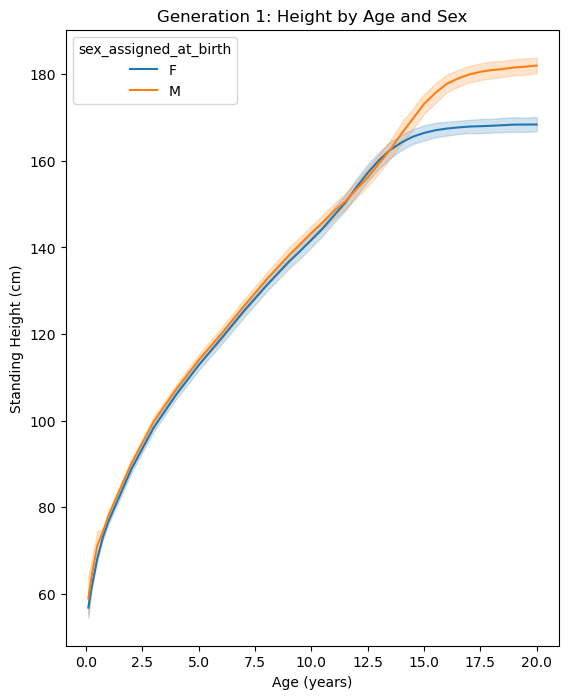

In [9]:
# Plot height distributions by age for both generations
plt.figure(figsize=(14, 8))

# Gen 1 plot
plt.subplot(1, 2, 1)
sns.lineplot(data=gen1_train, x='age', y='SHgt_cm', hue='sex_assigned_at_birth')
plt.title('Generation 1: Height by Age and Sex')
plt.xlabel('Age (years)')
plt.ylabel('Standing Height (cm)')

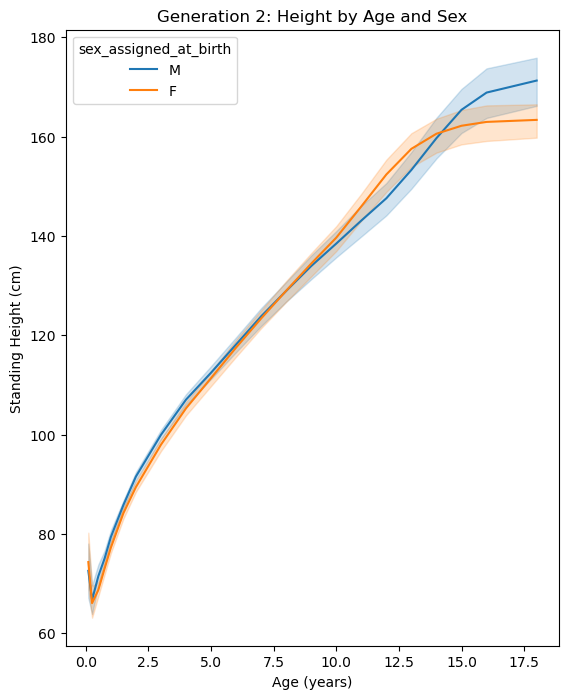

In [10]:
# Gen 2 plot
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 2)
sns.lineplot(data=gen2_train, x='AgeGr', y='SHgt_cm', hue='sex_assigned_at_birth')
plt.title('Generation 2: Height by Age and Sex')
plt.xlabel('Age (years)')
plt.ylabel('Standing Height (cm)')
plt.show()

In [11]:
# Create growth velocity calculations
# Function to calculate growth velocity for a subject
def calculate_growth_velocity(df, id_col, age_col, height_col):
    velocities = []
    for subject_id in df[id_col].unique():
        subject_data = df[df[id_col] == subject_id].sort_values(by=age_col)
        
        # Calculate velocity (cm/year)
        if len(subject_data) > 1:
            for i in range(1, len(subject_data)):
                prev = subject_data.iloc[i-1]
                curr = subject_data.iloc[i]
                
                age_diff = curr[age_col] - prev[age_col]
                height_diff = curr[height_col] - prev[height_col]
                
                if age_diff > 0:  # Avoid division by zero
                    velocity = height_diff / age_diff
                    
                    velocities.append({
                        'subject_id': subject_id,
                        'age': curr[age_col],
                        'velocity_cm_per_year': velocity,
                        'sex': curr['sex_assigned_at_birth'] if 'sex_assigned_at_birth' in curr else None
                    })
    
    return pd.DataFrame(velocities)

# Calculate velocities
gen1_velocities = calculate_growth_velocity(gen1_train, 'gen1_id', 'age', 'SHgt_cm')
gen2_velocities = calculate_growth_velocity(gen2_train, 'gen2_id', 'AgeGr', 'SHgt_cm')

Text(0, 0.5, 'Growth Velocity (cm/year)')

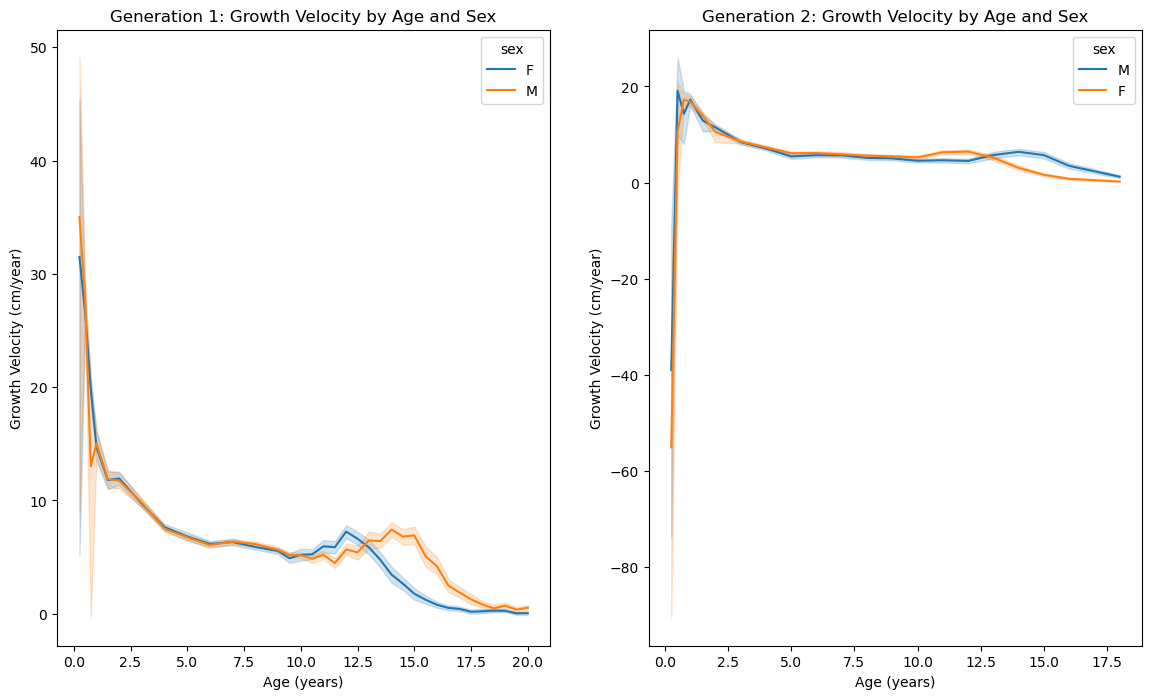

In [12]:
# Plot growth velocities
plt.figure(figsize=(14, 8))

# Gen 1 velocities
plt.subplot(1, 2, 1)
sns.lineplot(data=gen1_velocities, x='age', y='velocity_cm_per_year', hue='sex')
plt.title('Generation 1: Growth Velocity by Age and Sex')
plt.xlabel('Age (years)')
plt.ylabel('Growth Velocity (cm/year)')

# Gen 2 velocities
plt.subplot(1, 2, 2)
sns.lineplot(data=gen2_velocities, x='age', y='velocity_cm_per_year', hue='sex')
plt.title('Generation 2: Growth Velocity by Age and Sex')
plt.xlabel('Age (years)')
plt.ylabel('Growth Velocity (cm/year)')

In [13]:
# Extract features from parent growth curves and final heights of children
# First, create a function to extract key growth features for each subject

def extract_growth_features(df, id_col, age_col, height_col, velocities_df=None):
    features = []
    
    for subject_id in df[id_col].unique():
        subject_data = df[df[id_col] == subject_id].sort_values(by=age_col)
        
        if len(subject_data) < 5:  # Skip subjects with too few measurements
            continue
            
        # Basic features
        sex = subject_data['sex_assigned_at_birth'].iloc[0]
        
        # Extract height at key ages (using interpolation when necessary)
        heights_by_age = {}
        for age in [0, 1, 2, 5, 10, 15, 18]:
            closest_row = subject_data.iloc[(subject_data[age_col] - age).abs().argsort()[:1]]
            if not closest_row.empty:
                heights_by_age[f'height_at_age_{age}'] = closest_row[height_col].values[0]
            else:
                heights_by_age[f'height_at_age_{age}'] = np.nan
        
        # Calculate growth rates for different periods
        growth_rates = {}
        age_ranges = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 18)]
        
        for start_age, end_age in age_ranges:
            if f'height_at_age_{start_age}' in heights_by_age and f'height_at_age_{end_age}' in heights_by_age:
                if not np.isnan(heights_by_age[f'height_at_age_{start_age}']) and not np.isnan(heights_by_age[f'height_at_age_{end_age}']):
                    height_diff = heights_by_age[f'height_at_age_{end_age}'] - heights_by_age[f'height_at_age_{start_age}']
                    age_diff = end_age - start_age
                    growth_rates[f'growth_rate_{start_age}_to_{end_age}'] = height_diff / age_diff
        
        # Final adult height (assuming last measurement is adult height)
        if not subject_data.empty:
            final_height = subject_data.iloc[-1][height_col]
            final_age = subject_data.iloc[-1][age_col]
        else:
            final_height = np.nan
            final_age = np.nan
            
        # Growth spurt features (if velocities are provided)
        spurt_features = {}
        if velocities_df is not None:
            subject_velocities = velocities_df[velocities_df['subject_id'] == subject_id]
            
            if not subject_velocities.empty:
                # Find the pubertal growth spurt (maximum velocity between ages 9-15)
                pubertal_velocities = subject_velocities[(subject_velocities['age'] >= 9) & 
                                                       (subject_velocities['age'] <= 15)]
                
                if not pubertal_velocities.empty:
                    max_velocity_row = pubertal_velocities.loc[pubertal_velocities['velocity_cm_per_year'].idxmax()]
                    spurt_features['max_growth_velocity'] = max_velocity_row['velocity_cm_per_year']
                    spurt_features['age_at_max_velocity'] = max_velocity_row['age']
                    
                    # Calculate total growth during puberty (9-15)
                    height_at_9 = heights_by_age.get('height_at_age_10', np.nan)  # Using 10 as proxy if 9 not available
                    height_at_15 = heights_by_age.get('height_at_age_15', np.nan)
                    
                    if not np.isnan(height_at_9) and not np.isnan(height_at_15):
                        spurt_features['pubertal_growth_magnitude'] = height_at_15 - height_at_9
        
        # Combine all features
        subject_features = {
            'subject_id': subject_id,
            'sex': sex,
            'final_height': final_height,
            'final_age': final_age,
            **heights_by_age,
            **growth_rates,
            **spurt_features
        }
        
        features.append(subject_features)
    
    return pd.DataFrame(features)


In [14]:
# Extract features for both generations
gen1_features = extract_growth_features(gen1_train, 'gen1_id', 'age', 'SHgt_cm', gen1_velocities)
gen2_features = extract_growth_features(gen2_train, 'gen2_id', 'AgeGr', 'SHgt_cm', gen2_velocities)

In [15]:
# Create parent-child pairs
parent_child_pairs = pd.merge(
    gen2_train[['gen2_id', 'study_parent_id_new', 'sex_assigned_at_birth']].drop_duplicates(),
    gen1_features,
    left_on='study_parent_id_new',
    right_on='subject_id',
    how='inner'
)

In [16]:
# Rename columns to clarify they are parent features
parent_columns = gen1_features.columns.tolist()
for col in parent_columns:
    if col != 'subject_id':
        parent_child_pairs = parent_child_pairs.rename(columns={col: f'parent_{col}'})


In [17]:
# Merge with child features
parent_child_pairs = pd.merge(
    parent_child_pairs,
    gen2_features,
    left_on='gen2_id',
    right_on='subject_id',
    how='inner',
    suffixes=('', '_child')
)

In [18]:
print("\nParent-Child Pairs Shape:", parent_child_pairs.shape)


Parent-Child Pairs Shape: (151, 41)


In [19]:
# Analyze the relationship between parent features and child final height
# First, let's see which parent features correlate most with child's final height

# Prepare the data
X_cols = [col for col in parent_child_pairs.columns if 'parent_' in col and not parent_child_pairs[col].isnull().any()]
y_col = 'final_height'

# Filter out rows with NaN in target variable
valid_pairs = parent_child_pairs.dropna(subset=[y_col])
print(f"\nValid parent-child pairs for final height prediction: {len(valid_pairs)}")



Valid parent-child pairs for final height prediction: 151


In [20]:
# Correlation analysis
correlations = []
for col in X_cols:
    if valid_pairs[col].dtype == 'float64':
        corr = stats.pearsonr(valid_pairs[col], valid_pairs[y_col])[0]
        correlations.append((col, corr))
    else:
        continue

correlations.sort(key=lambda x: abs(x[1]), reverse=True)
print("\nTop 10 Parent Features Correlated with Child's Final Height:")
for col, corr in correlations[:10]:
    print(f"{col}: {corr:.4f}")


Top 10 Parent Features Correlated with Child's Final Height:
parent_final_age: nan
parent_age_at_max_velocity: 0.1927
parent_height_at_age_1: 0.1740
parent_height_at_age_2: 0.1581
parent_height_at_age_18: 0.1349
parent_final_height: 0.1345
parent_height_at_age_5: 0.1081
parent_height_at_age_15: 0.1055
parent_pubertal_growth_magnitude: 0.0915
parent_growth_rate_10_to_15: 0.0915


/var/folders/z4/gtdvl2k50kx0r_klc4vgllkh0000gn/T/ipykernel_55831/3695969799.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = stats.pearsonr(valid_pairs[col], valid_pairs[y_col])[0]


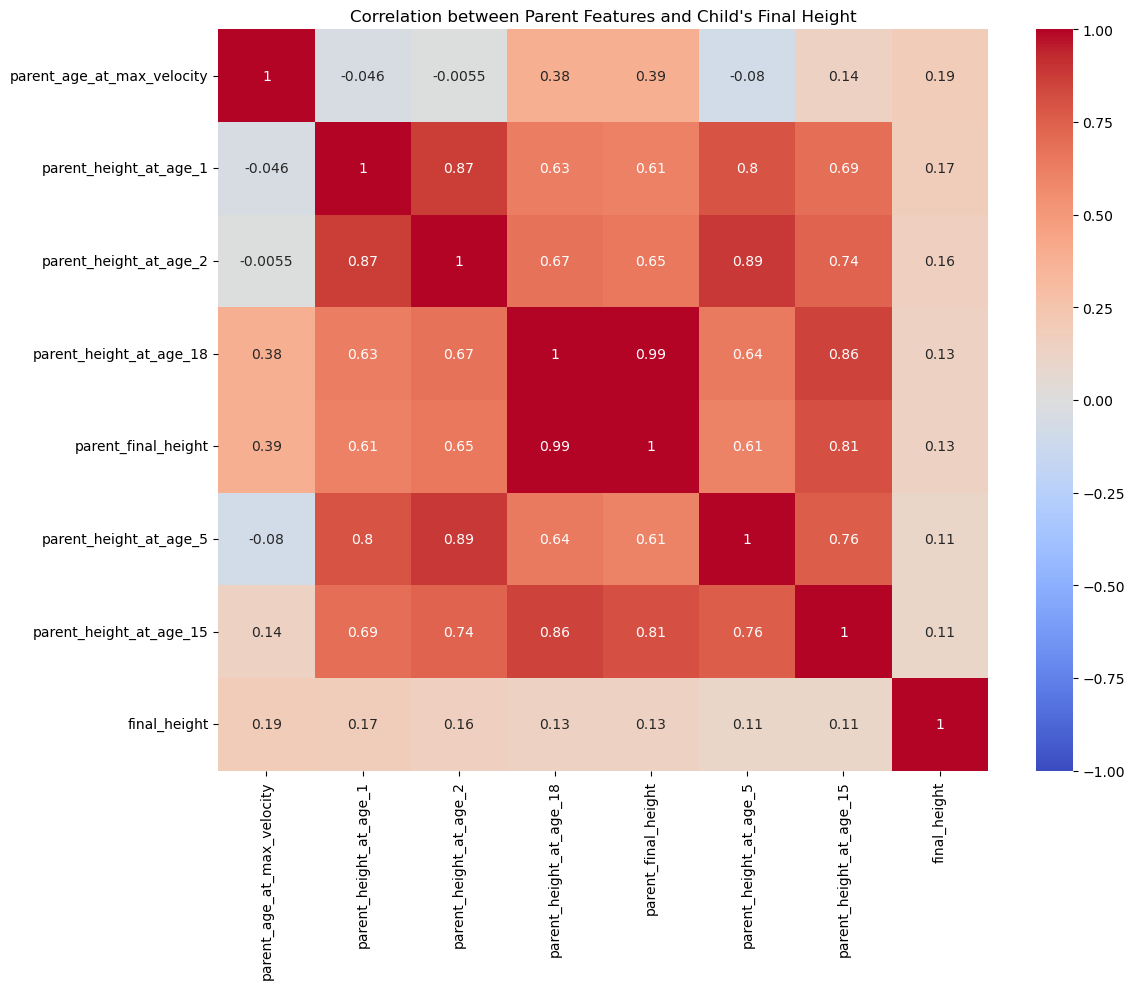

In [21]:
# Visualize top correlations
plt.figure(figsize=(12, 10))
top_features = [x[0] for x in correlations[1:8]]
correlation_data = valid_pairs[top_features + [y_col]]
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm',  vmin=-1, vmax=1, center=0)
plt.title("Correlation between Parent Features and Child's Final Height")
plt.tight_layout()
plt.show()

In [22]:
# Build a model to predict child's final height from parent features
X = valid_pairs[top_features]
y = valid_pairs[y_col]

In [23]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Create and train models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}
feature_importances = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'R2': r2}
    
    # Store feature importances if available
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importances[name] = dict(zip(top_features, importances))
    elif hasattr(model, 'coef_'):
        importances = model.coef_
        feature_importances[name] = dict(zip(top_features, importances))

In [25]:
# Print model results
print("\nModel Performance for Predicting Child's Final Height:")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  MSE: {metrics['MSE']:.4f}")
    print(f"  R2: {metrics['R2']:.4f}")


Model Performance for Predicting Child's Final Height:
Linear Regression:
  MSE: 402.2207
  R2: 0.0117
Ridge Regression:
  MSE: 402.4746
  R2: 0.0111
Random Forest:
  MSE: 339.4390
  R2: 0.1660


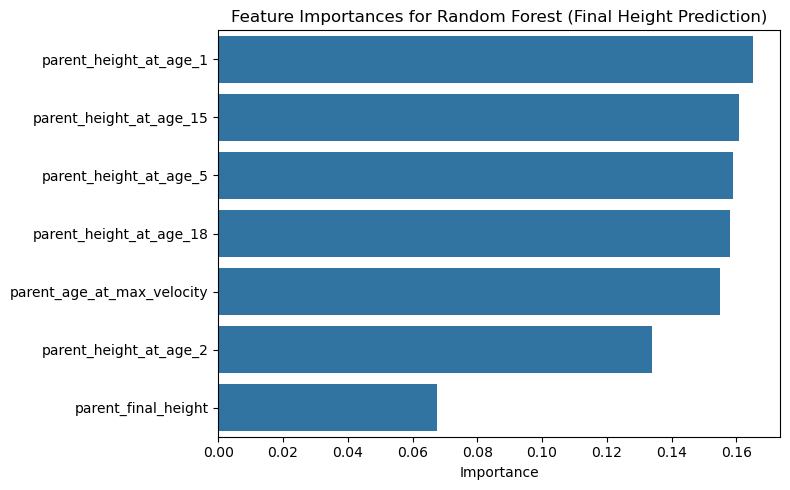

In [26]:
import matplotlib.pyplot as plt

# Identify the best model based on R2
best_model = max(results.items(), key=lambda x: x[1]['R2'])[0]

# Remove 'parent_final_age' feature from the importances
feature_importances[best_model].pop('parent_final_age', None)

# Ensure the best model has feature importances to plot
if best_model in feature_importances:
    plt.figure(figsize=(8, 5))
    
    importances = feature_importances[best_model]
    sorted_importances = sorted(importances.items(), key=lambda x: abs(x[1]), reverse=True)
    
    features = [x[0] for x in sorted_importances]
    values = [x[1] for x in sorted_importances]
    
    # Create horizontal bar plot with a custom blue color
    # plt.barh(features, values, color='#1f77b4')  # Set the color to a specific blue
    sns.barplot(y=features, x=values)

    # Add title and labels
    plt.title(f"Feature Importances for {best_model} (Final Height Prediction)")
    plt.xlabel('Importance')
    
    # Make the layout tight to avoid label clipping
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [27]:
# Part B: Predicting the magnitude of child's pubertal growth spurt
# First, identify children with complete growth data during puberty
valid_spurt_data = gen2_features.dropna(subset=['pubertal_growth_magnitude'])
print(f"\nChildren with valid pubertal growth data: {len(valid_spurt_data)}")

# Create parent-child pairs for growth spurt analysis
spurt_pairs = pd.merge(
    gen2_train[['gen2_id', 'study_parent_id_new']].drop_duplicates(),
    gen1_features,
    left_on='study_parent_id_new',
    right_on='subject_id',
    how='inner'
)


Children with valid pubertal growth data: 192


In [28]:
# Rename columns for clarity
for col in gen1_features.columns.tolist():
    if col != 'subject_id':
        spurt_pairs = spurt_pairs.rename(columns={col: f'parent_{col}'})

In [29]:
# Merge with child growth spurt data
spurt_pairs = pd.merge(
    spurt_pairs,
    valid_spurt_data[['subject_id', 'pubertal_growth_magnitude', 'max_growth_velocity', 'age_at_max_velocity']],
    left_on='gen2_id',
    right_on='subject_id',
    how='inner'
)

In [30]:
print(f"Parent-child pairs for growth spurt analysis: {len(spurt_pairs)}")

Parent-child pairs for growth spurt analysis: 151


In [31]:
# Correlation analysis for growth spurt
correlations_spurt = []
X_cols_spurt = [col for col in spurt_pairs.columns if 'parent_' in col and not spurt_pairs[col].isnull().any()]
y_col_spurt = 'pubertal_growth_magnitude'

for col in X_cols_spurt:
    if spurt_pairs[col].dtype == 'float64':
        corr = stats.pearsonr(spurt_pairs[col], spurt_pairs[y_col_spurt])[0]
        correlations_spurt.append((col, corr))
    else:
        continue

correlations_spurt.sort(key=lambda x: abs(x[1]), reverse=True)
print("\nTop 10 Parent Features Correlated with Child's Pubertal Growth Magnitude:")
for col, corr in correlations_spurt[:10]:
    print(f"{col}: {corr:.4f}")


Top 10 Parent Features Correlated with Child's Pubertal Growth Magnitude:
parent_final_age: nan
parent_age_at_max_velocity: 0.1784
parent_growth_rate_2_to_5: -0.1289
parent_growth_rate_10_to_15: 0.1078
parent_pubertal_growth_magnitude: 0.1078
parent_max_growth_velocity: 0.1033
parent_height_at_age_1: 0.0870
parent_growth_rate_5_to_10: -0.0712
parent_growth_rate_15_to_18: 0.0638
parent_final_height: 0.0541


/var/folders/z4/gtdvl2k50kx0r_klc4vgllkh0000gn/T/ipykernel_55831/3358727761.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = stats.pearsonr(spurt_pairs[col], spurt_pairs[y_col_spurt])[0]


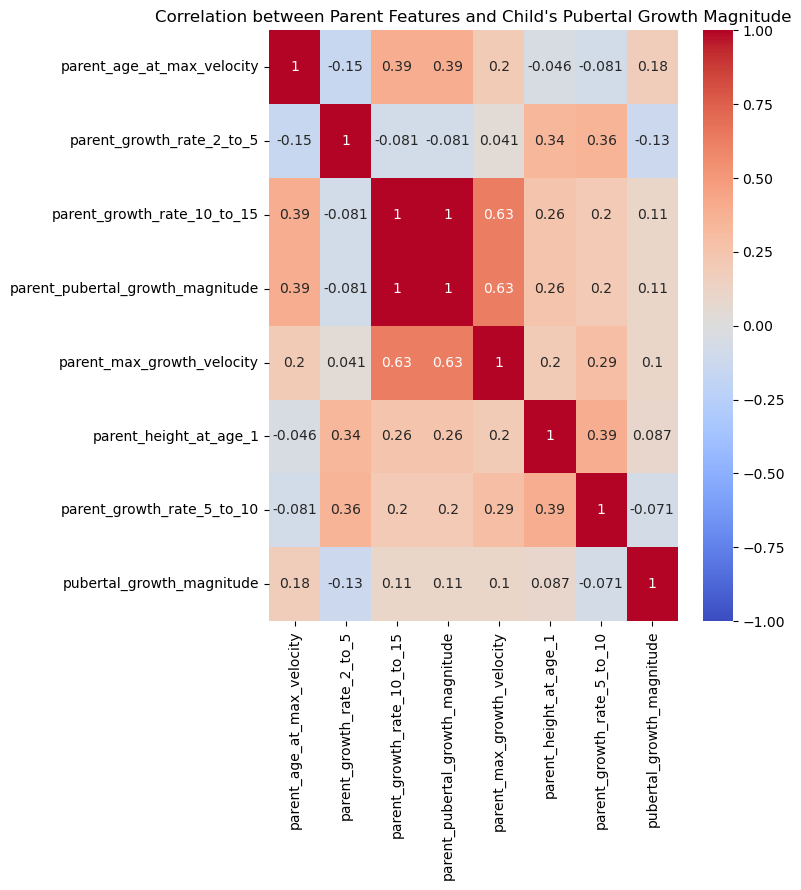

In [32]:
# Visualize top correlations for growth spurt
plt.figure(figsize=(8, 9))
top_spurt_features = [x[0] for x in correlations_spurt[1:8]]
spurt_correlation_data = spurt_pairs[top_spurt_features + [y_col_spurt]]
sns.heatmap(spurt_correlation_data.corr(), annot=True, cmap='coolwarm',  vmin=-1, vmax=1, center=0)
plt.title("Correlation between Parent Features and Child's Pubertal Growth Magnitude")
plt.tight_layout()
plt.show()

In [33]:
# Build a model to predict child's growth spurt magnitude
X_spurt = spurt_pairs[top_spurt_features]
y_spurt = spurt_pairs[y_col_spurt]

# Split the data
X_train_spurt, X_test_spurt, y_train_spurt, y_test_spurt = train_test_split(
    X_spurt, y_spurt, test_size=0.2, random_state=42
)

In [34]:
# Train and evaluate models
spurt_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

In [35]:
spurt_results = {}
spurt_feature_importances = {}

for name, model in spurt_models.items():
    # Train the model
    model.fit(X_train_spurt, y_train_spurt)
    
    # Predict
    y_pred_spurt = model.predict(X_test_spurt)
    
    # Evaluate
    mse = mean_squared_error(y_test_spurt, y_pred_spurt)
    r2 = r2_score(y_test_spurt, y_pred_spurt)
    
    spurt_results[name] = {'MSE': mse, 'R2': r2}
    
    # Store feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        spurt_feature_importances[name] = dict(zip(top_spurt_features, importances))
    elif hasattr(model, 'coef_'):
        importances = model.coef_
        spurt_feature_importances[name] = dict(zip(top_spurt_features, importances))

# Print model results for growth spurt prediction
print("\nModel Performance for Predicting Child's Pubertal Growth Magnitude:")
for name, metrics in spurt_results.items():
    print(f"{name}:")
    print(f"  MSE: {metrics['MSE']:.4f}")
    print(f"  R2: {metrics['R2']:.4f}")


Model Performance for Predicting Child's Pubertal Growth Magnitude:
Linear Regression:
  MSE: 122.8139
  R2: -0.0345
Ridge Regression:
  MSE: 121.0759
  R2: -0.0198
Random Forest:
  MSE: 116.7290
  R2: 0.0168


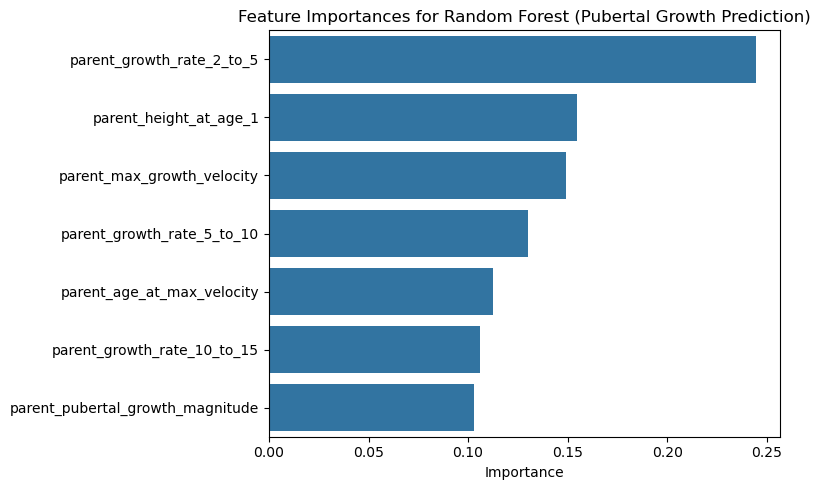

In [36]:
import matplotlib.pyplot as plt

# Identify the best model based on R2
best_spurt_model = max(spurt_results.items(), key=lambda x: x[1]['R2'])[0]

# Remove 'parent_final_age' feature from the importances
spurt_feature_importances[best_spurt_model].pop('parent_final_age', None)

# Ensure the best model has feature importances to plot
if best_spurt_model in spurt_feature_importances:
    plt.figure(figsize=(8, 5))
    
    importances = spurt_feature_importances[best_spurt_model]
    sorted_importances = sorted(importances.items(), key=lambda x: abs(x[1]), reverse=True)
    
    features = [x[0] for x in sorted_importances]
    values = [x[1] for x in sorted_importances]
    
    # Create horizontal bar plot with a custom blue color
    sns.barplot(y = features, x = values)  # Set the color to a specific blue
    
    # Add title and labels
    plt.title(f"Feature Importances for {best_spurt_model} (Pubertal Growth Prediction)")
    plt.xlabel('Importance')
    
    # Make the layout tight to avoid label clipping
    plt.tight_layout()
    
    # Show the plot
    plt.show()


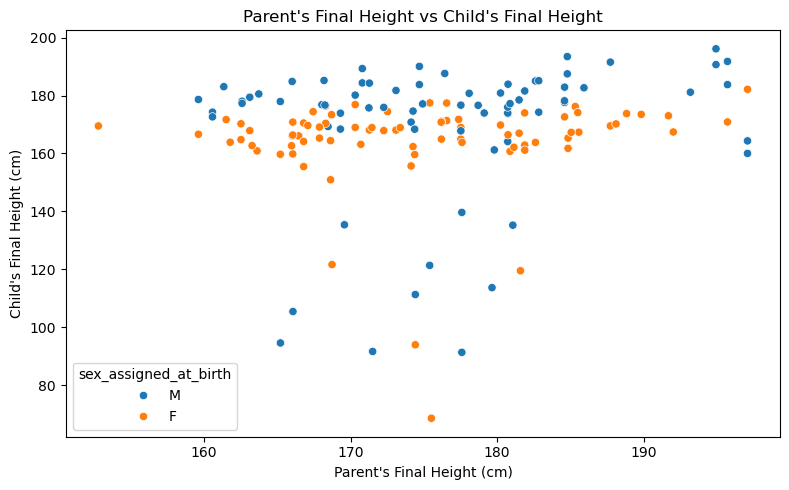

In [37]:
# Investigate specific relationships between key parent features and child growth outcomes
# Let's look at how parent's final height relates to child's final height
plt.figure(figsize=(8, 5))
sns.scatterplot(data=valid_pairs, x='parent_final_height', y='final_height', hue='sex_assigned_at_birth')
plt.title("Parent's Final Height vs Child's Final Height")
plt.xlabel("Parent's Final Height (cm)")
plt.ylabel("Child's Final Height (cm)")
plt.tight_layout()

## Part c

In [39]:
gen1_test = pd.read_csv('/Users/chinguyen/Desktop/USF-MSDS/Advance ML/final_project/adv_ML_VAT/csv/input/gen1_test_comp_final.csv')
gen2_test = pd.read_csv('/Users/chinguyen/Desktop/USF-MSDS/Advance ML/final_project/adv_ML_VAT/csv/input/gen2_test_upto9_comp_final.csv')

In [40]:
def prepare_parent_data(gen1_train, gen1_test):
    """
    Prepare parent heights data by combining train and test datasets
    
    Parameters:
    -----------
    gen1_train : DataFrame
        Training data for generation 1 (parents)
    gen1_test : DataFrame
        Test data for generation 1 (parents)
    
    Returns:
    --------
    DataFrame
        Combined parent heights data
    """
    parent_heights_train = (
        gen1_train.dropna(subset=['SHgt_cm'])
        .rename(columns={'age': 'parent_age', 'SHgt_cm': 'parent_height'})
        [['gen1_id', 'parent_age', 'parent_height']]
    )
    
    parent_heights_test = (
        gen1_test.dropna(subset=['SHgt_cm'])
        .rename(columns={'age': 'parent_age', 'SHgt_cm': 'parent_height'})
        [['gen1_id', 'parent_age', 'parent_height']]
    )
    
    return pd.concat([parent_heights_train, parent_heights_test], ignore_index=True)

In [41]:
def create_features(df, parent_data):
    """
    Create features for height prediction with robust NaN handling
    
    Parameters:
    -----------
    df : DataFrame
        Generation 2 data (children)
    parent_data : DataFrame
        Parent heights data
    
    Returns:
    --------
    DataFrame
        Features for model training/prediction
    """
    # Merge with parent data
    merged = pd.merge(
        df,
        parent_data,
        left_on=['study_parent_id_new', 'AgeGr'],
        right_on=['gen1_id', 'parent_age'],
        how='left'
    )
    
    # Extract gender features - categorical to numeric
    merged['is_male'] = (merged['sex_assigned_at_birth'] == 'M').astype(int)
    merged['parent_is_mother'] = (merged['study_parent_sex'] == 'mother').astype(int)
    
    # Parent-child gender interaction
    parent_child_same_gender = ((merged['sex_assigned_at_birth'] == 'M') & 
                              (merged['study_parent_sex'] == 'father')) | \
                             ((merged['sex_assigned_at_birth'] == 'F') & 
                              (merged['study_parent_sex'] == 'mother'))
    merged['parent_child_same_gender'] = parent_child_same_gender.astype(int)
    
    # Calculate BMI if weight data is available (with NaN safety)
    if 'Wgt_kg' in merged.columns:
        # Safe division with proper NaN handling
        merged['bmi'] = np.where(
            (merged['Wgt_kg'].notna()) & (merged['SHgt_cm'].notna()) & (merged['SHgt_cm'] > 0),
            merged['Wgt_kg'] / ((merged['SHgt_cm']/100)**2),
            np.nan
        )

    features = []
    # Process each subject individually
    for subject_id in merged['gen2_id'].unique():
        subject_data = merged[merged['gen2_id'] == subject_id].sort_values('AgeGr')
        
        # Get gender information (these should be consistent within a subject)
        is_male = subject_data['is_male'].iloc[0] if not subject_data.empty else 0
        parent_is_mother = subject_data['parent_is_mother'].iloc[0] if not subject_data.empty else 0
        parent_child_same_gender = subject_data['parent_child_same_gender'].iloc[0] if not subject_data.empty else 0
        
        # Extract early measurements (age <= 9) - with robust filtering
        early_data = subject_data[subject_data['AgeGr'] <= 9]
        early_heights = early_data['SHgt_cm'].values if not early_data.empty else np.array([])
        early_ages = early_data['AgeGr'].values if not early_data.empty else np.array([])
        
        # Extract later measurements (10 <= age <= 18) - with robust filtering
        later_data = subject_data[(subject_data['AgeGr'] >= 10) & (subject_data['AgeGr'] <= 18)]
        later_heights = later_data['SHgt_cm'].values if not later_data.empty else np.array([])
        later_ages = later_data['AgeGr'].values if not later_data.empty else np.array([])

        # Growth velocity calculation with NaN safety
        growth_velocity = np.nan
        if len(early_heights) >= 2 and len(early_ages) >= 2:
            age_diff = early_ages[-1] - early_ages[0]
            if age_diff > 0:  # Prevent division by zero
                growth_velocity = (early_heights[-1] - early_heights[0]) / age_diff

        # Peak Growth Rate calculation with NaN safety
        peak_growth_rate, age_peak_growth = np.nan, np.nan
        if len(later_heights) >= 2 and len(later_ages) >= 2:
            # Calculate growth rates between consecutive measurements
            age_diffs = np.diff(later_ages)
            height_diffs = np.diff(later_heights)
            
            # Only calculate rates where age difference is positive (to avoid division by zero)
            valid_indices = age_diffs > 0
            if np.any(valid_indices):
                growth_rates = np.full_like(age_diffs, np.nan, dtype=float)
                growth_rates[valid_indices] = height_diffs[valid_indices] / age_diffs[valid_indices]
                
                # Find max growth rate if there are valid rates
                if not np.all(np.isnan(growth_rates)):
                    peak_growth_rate = np.nanmax(growth_rates)
                    # Find index of max growth rate
                    max_idx = np.nanargmax(growth_rates)
                    age_peak_growth = later_ages[max_idx + 1]

        # Extract key height measurements with NaN safety
        height_at_6 = subject_data[subject_data['AgeGr'] == 6]['SHgt_cm'].iloc[0] if not subject_data[subject_data['AgeGr'] == 6].empty else np.nan
        height_at_9 = subject_data[subject_data['AgeGr'] == 9]['SHgt_cm'].iloc[0] if not subject_data[subject_data['AgeGr'] == 9].empty else np.nan
        height_at_12 = subject_data[subject_data['AgeGr'] == 12]['SHgt_cm'].iloc[0] if not subject_data[subject_data['AgeGr'] == 12].empty else np.nan
        
        # Parent height at maturity (age 18)
        parent_height_18 = subject_data[subject_data['parent_age'] == 18]['parent_height'].iloc[0] if not subject_data[subject_data['parent_age'] == 18].empty else np.nan

        # Get parent ID to extract parent growth data
        parent_id = subject_data['gen1_id'].iloc[0] if not subject_data.empty else None
        
        # Extract parent peak growth rate and age
        parent_peak_growth_rate, parent_peak_growth_age = np.nan, np.nan
        if parent_id is not None:
            parent_data_sorted = parent_data[parent_data['gen1_id'] == parent_id].sort_values('parent_age')
            if len(parent_data_sorted) >= 2:
                parent_ages = parent_data_sorted['parent_age'].values
                parent_heights = parent_data_sorted['parent_height'].values
                
                # Calculate parent growth rates
                parent_age_diffs = np.diff(parent_ages)
                parent_height_diffs = np.diff(parent_heights)
                
                valid_indices = parent_age_diffs > 0
                if np.any(valid_indices):
                    parent_growth_rates = np.full_like(parent_age_diffs, np.nan, dtype=float)
                    parent_growth_rates[valid_indices] = parent_height_diffs[valid_indices] / parent_age_diffs[valid_indices]
                    
                    if not np.all(np.isnan(parent_growth_rates)):
                        parent_peak_growth_rate = np.nanmax(parent_growth_rates)
                        max_idx = np.nanargmax(parent_growth_rates)
                        parent_peak_growth_age = parent_ages[max_idx + 1]

        # Calculate derived features with NaN safety
        height_diff_9_6 = np.nan
        if pd.notna(height_at_9) and pd.notna(height_at_6):
            height_diff_9_6 = height_at_9 - height_at_6
            
        height_diff_12_9 = np.nan
        if pd.notna(height_at_12) and pd.notna(height_at_9):
            height_diff_12_9 = height_at_12 - height_at_9
            
        growth_rate_change = np.nan
        if pd.notna(peak_growth_rate) and pd.notna(growth_velocity):
            growth_rate_change = peak_growth_rate - growth_velocity
            
        parent_child_height_diff = np.nan
        parent_child_height_ratio = np.nan
        if pd.notna(height_at_9) and pd.notna(parent_height_18) and parent_height_18 > 0:
            parent_child_height_diff = height_at_9 - parent_height_18
            parent_child_height_ratio = height_at_9 / parent_height_18
            
        # Get BMI if available
        bmi_at_9 = subject_data[subject_data['AgeGr'] == 9]['bmi'].iloc[0] if 'bmi' in subject_data.columns and not subject_data[subject_data['AgeGr'] == 9].empty else np.nan

        # Create a row for each target age (10-18)
        for target_age in range(10, 19):
            row_data = {
                'gen2_id': subject_id,
                'AgeGr': target_age,
                'last_height': early_heights[-1] if len(early_heights) > 0 else np.nan,
                'last_age': early_ages[-1] if len(early_ages) > 0 else np.nan,
                'growth_velocity': growth_velocity,
                'parent_height_18': parent_height_18,
                'height_at_9': height_at_9,
                'height_diff_9_6': height_diff_9_6,
                'height_diff_12_9': height_diff_12_9,
                'growth_rate_change': growth_rate_change,
                'peak_growth_rate': peak_growth_rate,
                'age_peak_growth': age_peak_growth,
                'parent_peak_growth_rate': parent_peak_growth_rate,
                'parent_peak_growth_age': parent_peak_growth_age,
                'parent_child_height_diff': parent_child_height_diff,
                'parent_child_height_ratio': parent_child_height_ratio,
                'is_male': is_male,
                'parent_is_mother': parent_is_mother,
                'parent_child_same_gender': parent_child_same_gender
            }
            
            # Add BMI if available
            if 'bmi' in subject_data.columns:
                row_data['bmi_at_9'] = bmi_at_9
                
            features.append(row_data)
    
    return pd.DataFrame(features)

In [42]:
def prepare_train_data(train_features, gen2_train):
    """
    Add actual height values to training features
    
    Parameters:
    -----------
    train_features : DataFrame
        Features created for training
    gen2_train : DataFrame
        Original gen2 training data with actual heights
    
    Returns:
    --------
    DataFrame
        Training features with actual height values
    """
    train_with_target = pd.merge(
        train_features,
        gen2_train[['gen2_id', 'AgeGr', 'SHgt_cm']],
        on=['gen2_id', 'AgeGr'],
        how='left'
    )
    return train_with_target.dropna(subset=['SHgt_cm'])

In [43]:
parent_heights = prepare_parent_data(gen1_train, gen1_test)
train_features = create_features(gen2_train, parent_heights)

train_features.head()

,gen2_id,AgeGr,last_height,last_age,growth_velocity,parent_height_18,height_at_9,height_diff_9_6,height_diff_12_9,growth_rate_change,peak_growth_rate,age_peak_growth,parent_peak_growth_rate,parent_peak_growth_age,parent_child_height_diff,parent_child_height_ratio,is_male,parent_is_mother,parent_child_same_gender,bmi_at_9
0,3012,10,143.319816,9.0,9.782943,180.441848,143.319816,18.085276,18.329613,0.235763,10.018706,13.0,54.781024,0.25,-37.122032,0.794271,1,1,0,21.221543
1,3012,11,143.319816,9.0,9.782943,180.441848,143.319816,18.085276,18.329613,0.235763,10.018706,13.0,54.781024,0.25,-37.122032,0.794271,1,1,0,21.221543
2,3012,12,143.319816,9.0,9.782943,180.441848,143.319816,18.085276,18.329613,0.235763,10.018706,13.0,54.781024,0.25,-37.122032,0.794271,1,1,0,21.221543
3,3012,13,143.319816,9.0,9.782943,180.441848,143.319816,18.085276,18.329613,0.235763,10.018706,13.0,54.781024,0.25,-37.122032,0.794271,1,1,0,21.221543
4,3012,14,143.319816,9.0,9.782943,180.441848,143.319816,18.085276,18.329613,0.235763,10.018706,13.0,54.781024,0.25,-37.122032,0.794271,1,1,0,21.221543


# Investigating the heritability of Growth spurt timing

Correlation between child and parent peak growth age: 0.1595


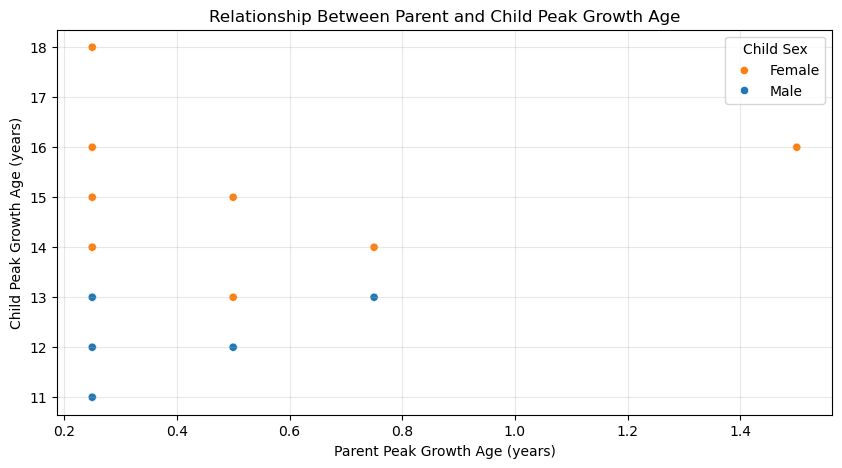

In [44]:
# Investigating the heritability of Growth spurt timing
# Focus on age of peak growth as the predictor and parent variables

# First, let's create a subset of the data with only the relevant columns
growth_timing_data = train_features[['gen2_id', 'age_peak_growth', 'parent_peak_growth_age', 
                                    'parent_height_18', 'is_male', 'parent_is_mother', 
                                    'parent_child_same_gender', 'parent_child_height_ratio', 'parent_child_height_diff',
                                    'parent_peak_growth_rate']].drop_duplicates()

# Calculate correlation between child and parent peak growth age
correlation = growth_timing_data['age_peak_growth'].corr(growth_timing_data['parent_peak_growth_age'])
print(f"Correlation between child and parent peak growth age: {correlation:.4f}")

# Visualize the relationship between parent and child peak growth age
plt.figure(figsize=(10, 5))
sns.scatterplot(x='parent_peak_growth_age', y='age_peak_growth', 
                hue='is_male', data=growth_timing_data)
plt.title('Relationship Between Parent and Child Peak Growth Age')
plt.xlabel('Parent Peak Growth Age (years)')
plt.ylabel('Child Peak Growth Age (years)')
plt.legend(title='Child Sex', labels=['Female', 'Male'])
plt.grid(True, alpha=0.3)
plt.show()

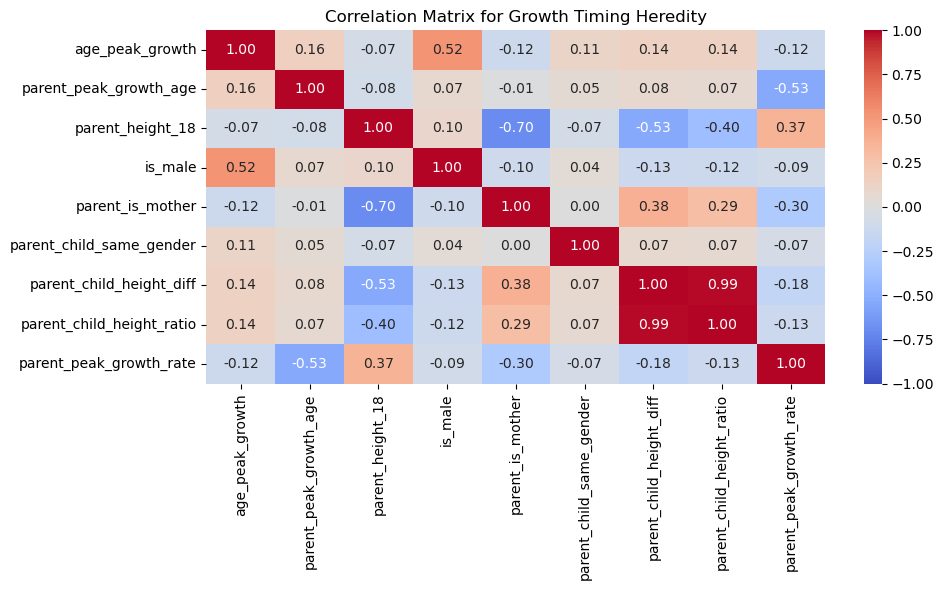

In [45]:
# Create a correlation matrix for relevant variables
correlation_vars = ['age_peak_growth', 'parent_peak_growth_age', 'parent_height_18', 
                    'is_male', 'parent_is_mother', 'parent_child_same_gender', 'parent_child_height_diff',
                    'parent_child_height_ratio', 'parent_peak_growth_rate']
correlation_matrix = growth_timing_data[correlation_vars].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix for Growth Timing Heredity')
plt.tight_layout()
plt.show()

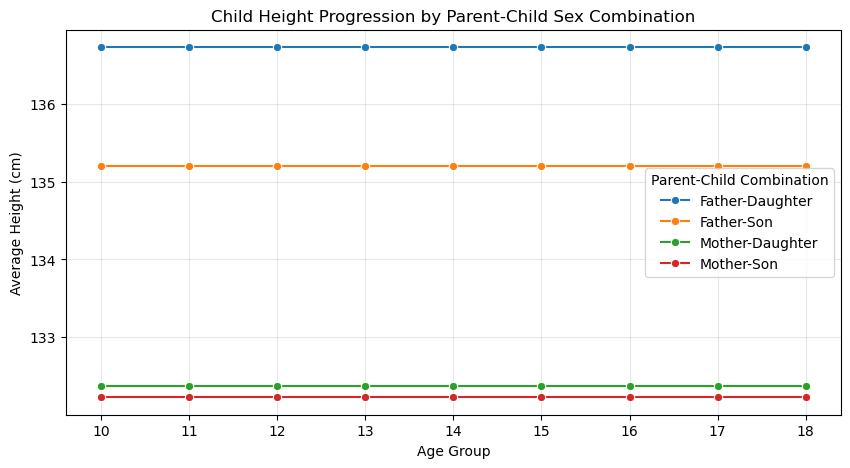

Correlation between parent and child height by sex combination:
       Combination  Correlation
0       Mother-Son     0.025768
1  Mother-Daughter    -0.201218
2  Father-Daughter     0.524553
3       Father-Son     0.675856


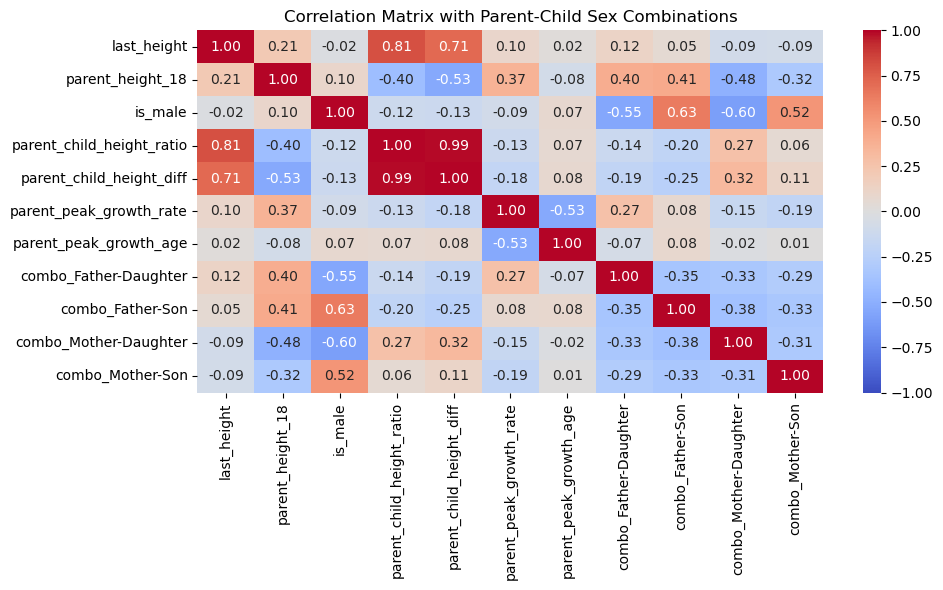

In [47]:
# Investigating the impact of parent-child sex combinations on child height prediction
# Create a subset of data with relevant columns including the new parent_child_sex_combo column

# First, ensure we have the parent_child_sex_combo column
train_features['parent_child_sex_combo'] = 'Other'
train_features.loc[(train_features['is_male'] == 1) & (train_features['parent_is_mother'] == 1), 'parent_child_sex_combo'] = 'Mother-Son'
train_features.loc[(train_features['is_male'] == 0) & (train_features['parent_is_mother'] == 1), 'parent_child_sex_combo'] = 'Mother-Daughter'
train_features.loc[(train_features['is_male'] == 1) & (train_features['parent_is_mother'] == 0), 'parent_child_sex_combo'] = 'Father-Son'
train_features.loc[(train_features['is_male'] == 0) & (train_features['parent_is_mother'] == 0), 'parent_child_sex_combo'] = 'Father-Daughter'

# Create a subset with relevant columns
height_prediction_data = train_features[['gen2_id', 'AgeGr', 'last_height', 'parent_height_18', 
                                        'is_male', 'parent_child_sex_combo', 'parent_peak_growth_rate', 'parent_peak_growth_age',
                                        'parent_child_height_ratio', 'parent_child_height_diff']].drop_duplicates()

# Analyze average height by age group and parent-child sex combination
height_by_combo_age = train_features.groupby(['parent_child_sex_combo', 'AgeGr'])['last_height'].mean().reset_index()

# Visualize height progression by parent-child sex combination
plt.figure(figsize=(10, 5))
sns.lineplot(x='AgeGr', y='last_height', hue='parent_child_sex_combo', data=height_by_combo_age, marker='o')
plt.title('Child Height Progression by Parent-Child Sex Combination')
plt.xlabel('Age Group')
plt.ylabel('Average Height (cm)')
plt.grid(True, alpha=0.3)
plt.legend(title='Parent-Child Combination')
plt.show()

# Calculate correlation between parent height and child height for each combination
correlations = []
for combo in train_features['parent_child_sex_combo'].unique():
    subset = train_features[train_features['parent_child_sex_combo'] == combo]
    corr = subset['last_height'].corr(subset['parent_height_18'])
    correlations.append({'Combination': combo, 'Correlation': corr})

corr_df = pd.DataFrame(correlations)
print("Correlation between parent and child height by sex combination:")
print(corr_df)

# Visualize the correlation matrix for relevant variables including the sex combination
# Convert categorical variable to dummy variables for correlation analysis
combo_dummies = pd.get_dummies(height_prediction_data['parent_child_sex_combo'], prefix='combo')
height_prediction_data_encoded = pd.concat([height_prediction_data.drop('parent_child_sex_combo', axis=1), combo_dummies], axis=1)

correlation_vars = ['last_height', 'parent_height_18', 'is_male', 
                    'parent_child_height_ratio', 'parent_child_height_diff',
                    'parent_peak_growth_rate', 'parent_peak_growth_age'] + list(combo_dummies.columns)
correlation_matrix = height_prediction_data_encoded[correlation_vars].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix with Parent-Child Sex Combinations')
plt.tight_layout()
plt.show()


In [48]:
# Analysis of Parent/Child Heredity Across Sex Combinations

# Create a new column that categorizes the parent-child sex combinations
train_features['parent_child_sex_combo'] = 'Other'
train_features.loc[(train_features['is_male'] == 1) & (train_features['parent_is_mother'] == 1), 'parent_child_sex_combo'] = 'Mother-Son'
train_features.loc[(train_features['is_male'] == 0) & (train_features['parent_is_mother'] == 1), 'parent_child_sex_combo'] = 'Mother-Daughter'
train_features.loc[(train_features['is_male'] == 1) & (train_features['parent_is_mother'] == 0), 'parent_child_sex_combo'] = 'Father-Son'
train_features.loc[(train_features['is_male'] == 0) & (train_features['parent_is_mother'] == 0), 'parent_child_sex_combo'] = 'Father-Daughter'

# Group data by parent-child sex combinations and calculate mean values for key metrics
heredity_by_sex_combo = train_features.groupby('parent_child_sex_combo').agg({
    'parent_child_height_diff': 'mean',
    'parent_child_height_ratio': 'mean',
    'parent_height_18': 'mean',
    'last_height': 'mean',
    'parent_peak_growth_age': 'mean',
    'peak_growth_rate': 'mean',
    'age_peak_growth': 'mean'
}).reset_index()

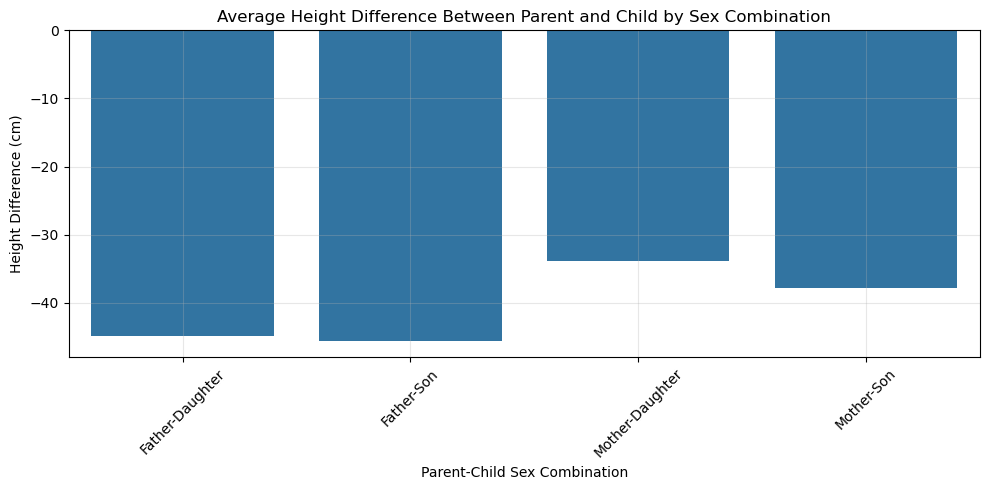

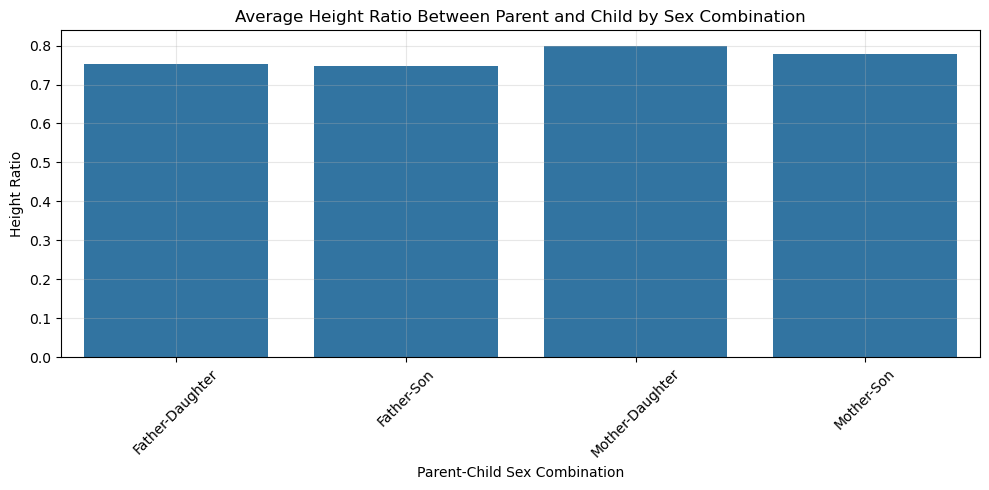

/var/folders/z4/gtdvl2k50kx0r_klc4vgllkh0000gn/T/ipykernel_55831/2598742686.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/var/folders/z4/gtdvl2k50kx0r_klc4vgllkh0000gn/T/ipykernel_55831/2598742686.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


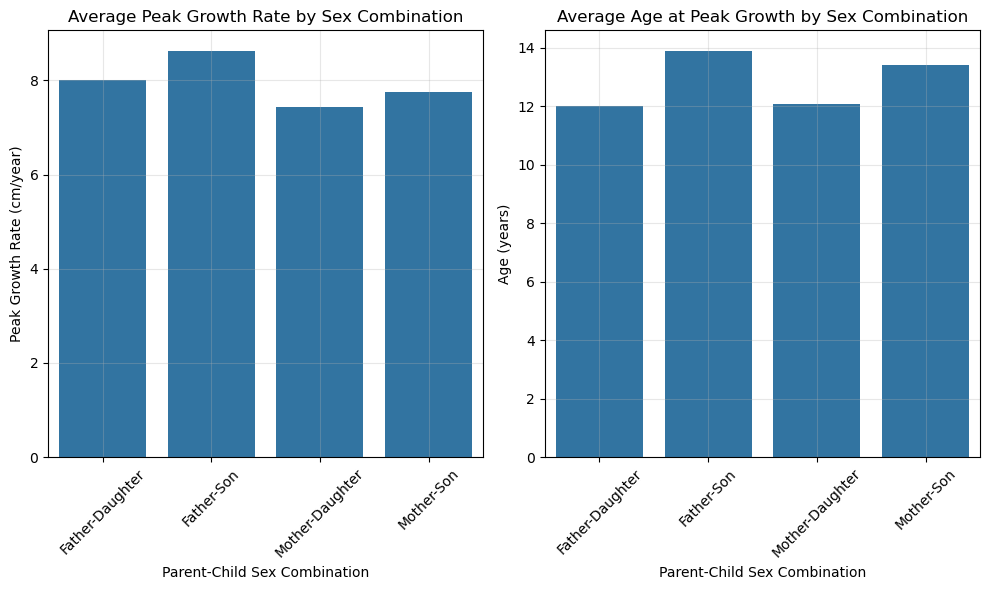

In [49]:
# Visualize the heredity metrics by parent-child sex combinations
plt.figure(figsize=(10, 5))
sns.barplot(x='parent_child_sex_combo', y='parent_child_height_diff', data=heredity_by_sex_combo)
plt.title('Average Height Difference Between Parent and Child by Sex Combination')
plt.xlabel('Parent-Child Sex Combination')
plt.ylabel('Height Difference (cm)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize height ratio by parent-child sex combinations
plt.figure(figsize=(10, 5))
sns.barplot(x='parent_child_sex_combo', y='parent_child_height_ratio', data=heredity_by_sex_combo)
plt.title('Average Height Ratio Between Parent and Child by Sex Combination')
plt.xlabel('Parent-Child Sex Combination')
plt.ylabel('Height Ratio')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize peak growth metrics by parent-child sex combinations
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot peak growth rate
sns.barplot(x='parent_child_sex_combo', y='peak_growth_rate', data=heredity_by_sex_combo, ax=axes[0])
axes[0].set_title('Average Peak Growth Rate by Sex Combination')
axes[0].set_xlabel('Parent-Child Sex Combination')
axes[0].set_ylabel('Peak Growth Rate (cm/year)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].grid(True, alpha=0.3)

# Plot age at peak growth
sns.barplot(x='parent_child_sex_combo', y='age_peak_growth', data=heredity_by_sex_combo, ax=axes[1])
axes[1].set_title('Average Age at Peak Growth by Sex Combination')
axes[1].set_xlabel('Parent-Child Sex Combination')
axes[1].set_ylabel('Age (years)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Predicting final height based on parent-child relationships
Model Performance Metrics for Height Prediction:
Linear Regression R²: 0.088291, MSE: 74.439260
Ridge Regression R²: 0.086030, MSE: 74.623911
Random Forest Regressor R²: 0.284197, MSE: 58.443901


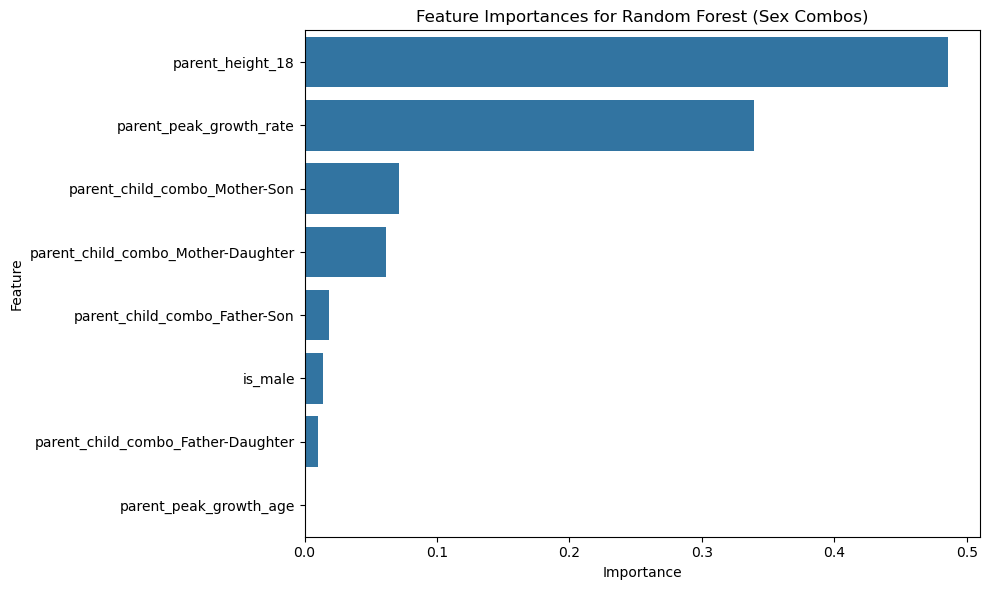

In [50]:
# Predicting final height based on parent-child relationships
print("Predicting final height based on parent-child relationships")

# Create a subset for height prediction analysis
height_prediction_subset = train_features[['gen2_id', 'last_height', 'parent_height_18', 
                                          'is_male', 'parent_child_sex_combo',
                                          'parent_peak_growth_rate', 'parent_peak_growth_age']].drop_duplicates()

# Drop rows with NaN values
height_prediction_subset = height_prediction_subset.dropna()

# Create dummy variables for parent_child_sex_combo
parent_child_dummies = pd.get_dummies(height_prediction_subset['parent_child_sex_combo'], 
                                      prefix='parent_child_combo')
height_prediction_subset = pd.concat([height_prediction_subset, parent_child_dummies], axis=1)

# Drop the original categorical column
height_prediction_subset = height_prediction_subset.drop('parent_child_sex_combo', axis=1)

# Split the data into features and target
X = height_prediction_subset.drop(['gen2_id', 'last_height'], axis=1)
y = height_prediction_subset['last_height']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
lr_model = LinearRegression()
ridge_model = Ridge()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train models
lr_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate models
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print model performance
print("Model Performance Metrics for Height Prediction:")
print(f"Linear Regression R²: {r2_lr:.6f}, MSE: {mse_lr:.6f}")
print(f"Ridge Regression R²: {r2_ridge:.6f}, MSE: {mse_ridge:.6f}")
print(f"Random Forest Regressor R²: {r2_rf:.6f}, MSE: {mse_rf:.6f}")

# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importances for Random Forest (Sex Combos)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()